# Load and setup the data and variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score

In [2]:
mouse_genes = pd.read_csv("../../data/prepared/mouse_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
human_genes = pd.read_csv("../../data/prepared/human_scaled.tsv.gz", sep="\t", header=0, index_col=[0,1])
mouse_genes.head().iloc[:,:5]

Xkr4     Gm1992  Gm37381        Rp1     Mrpl15
celltype        donor_id                                                     
Astro Aqp4_Gfap F003      72.332495  30.015894      0.0  22.366340  84.082359
                F004      55.310282  13.909523      0.0  13.909523  90.009749
                F005      71.144878  17.936119      0.0   0.000000  82.594443
                F008      35.518438  15.420245      0.0   9.053068  86.638046
                M002      52.345083   0.000000      0.0   0.000000  88.091092

In [3]:
mouse_genes.shape

(322, 18570)

In [4]:
human_genes.shape

(158, 12202)

We have to capitalize all of the mouse gene names.

In [5]:
mouse_genes.columns = [gene.upper() for gene in mouse_genes.columns]
mouse_genes.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=18570)

We're only interested in celltypes that are shared between the two species.

In [6]:
genes = list(set(mouse_genes.columns).intersection(human_genes.columns))
len(genes)

10956

In [7]:
mouse_genes = mouse_genes.loc[:,genes].T
human_genes = human_genes.loc[:,genes].T
mouse_genes.head().iloc[:,:5]

celltype Astro Aqp4_Gfap                                            
donor_id            F003       F004       F005       F008       M002
MRPL37         66.892963  48.034586  51.236691  50.623517  52.345083
TMEM150C       84.821021  84.257094  89.154269  88.422228  87.037483
NEK6           63.207998  77.007409  76.631930  72.206719  74.133464
PDIA5          17.173177   0.000000  31.187573  15.420245  22.758120
POF1B           0.000000  13.909523   0.000000   0.000000   0.000000

# Retrieve gene correlation network

In [9]:
import igraph as ig
import leidenalg as la
# from umap import UMAP

In [10]:
from scipy.stats import rankdata

In [11]:
from numpy import corrcoef

In [12]:
corr_mouse = corrcoef(mouse_genes.values, mouse_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [13]:
corr_human = corrcoef(human_genes.values, human_genes.values)[:human_genes.shape[0], :human_genes.shape[0]]

In [14]:
corr_human.shape

(10956, 10956)

In [15]:
def get_comparative_inds(corr_a, corr_b, n_idx = 30):
    """
    Identifies the top n indecies in a for each row in a, 
    as well as the ranks of the corresponding indexs for the same row in be b
    
    
    inputs:
        corr_a : a matrix of correlation coefficients
        corr_b : a different matrix of correlation coefficients
        n_idx : the number of indicies to check
    """
    
    top_n_a = np.argsort(corr_a)[:, -(n_idx+1):-1]
    idx_ranks_b = rankdata(corr_b, axis=0)
    idx_ranks_b = idx_ranks_b
#     ranks_in_b = [idx_ranks_b[i, top_n_a[i]][::-1] for i in range(len(corr_a))] 
    return idx_ranks_b, top_n_a

In [16]:
# top N co-expressed genes species a
# rank coexpression for species b
# get auroc of ranks, where true positives are top N in a

In [17]:
m_ranks, top_in_h = get_comparative_inds(corr_human, corr_mouse)

In [18]:
h_ranks, top_in_m = get_comparative_inds(corr_mouse, corr_human)

In [19]:
aucs_htom=[]
for i in range(m_ranks.shape[0]):
    labels = np.zeros(top_in_h.shape[0])
    labels[top_in_h[i]] = 1
    aucs_htom.append(roc_auc_score(y_true=labels, y_score=m_ranks[i]))

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   2.,   1.,
          3.,   4.,   8.,   8.,   4.,  10.,  10.,  14.,  23.,  18.,  19.,
         21.,  24.,  32.,  27.,  33.,  32.,  40.,  49.,  61.,  49.,  64.,
         66.,  76.,  70.,  83.,  82.,  83., 105., 119., 119.,  94., 118.,
        123., 149., 160., 160., 168., 174., 162., 172., 193., 197., 192.,
        204., 211., 221., 203., 232., 215., 203., 229., 226., 228., 227.,
        220., 203., 235., 203., 221., 240., 201., 186., 220., 241., 242.,
        225., 223., 173., 164., 171., 176., 179., 181., 152., 165., 144.,
        139., 140., 106., 104.,  90.,  63.,  50.,  28.,  24.,  12.,   8.,
          3.]),
 array([0.07967692, 0.08869917, 0.09772143, 0.10674368, 0.11576594,
        0.1247882 , 0.13381045, 0.14283271, 0.15185496, 0.16087722,
        0.16989948, 0.17892173, 0.18794399, 0.19696624, 0.2059885 ,
        0.21501075, 0.22403301, 0.23305527, 0.24207752, 0.25109978,
        0.26012203, 0.26914429, 0.27816654, 0.

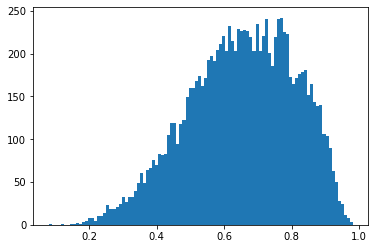

In [20]:
plt.hist(aucs_htom, bins=100)

In [21]:
aucs_mtoh=[]
for i in range(h_ranks.shape[0]):
    labels = np.zeros(top_in_m.shape[0])
    labels[top_in_m[i]] = 1
    aucs_mtoh.append(roc_auc_score(y_true=labels, y_score=h_ranks[i]))

(array([  1.,   0.,   1.,   0.,   1.,   2.,   2.,   0.,   3.,   4.,   4.,
          7.,   8.,  11.,  11.,  10.,   4.,  12.,   9.,  14.,  24.,  26.,
         24.,  34.,  30.,  35.,  33.,  49.,  49.,  46.,  44.,  61.,  60.,
         65.,  84.,  80.,  99.,  96.,  96., 104., 126., 124., 146., 144.,
        128., 164., 167., 173., 176., 166., 190., 198., 193., 194., 201.,
        219., 214., 218., 226., 225., 194., 199., 239., 212., 217., 219.,
        215., 256., 239., 211., 226., 201., 207., 187., 223., 198., 207.,
        200., 202., 189., 179., 151., 164., 172., 148., 123., 155., 143.,
        104., 110.,  85.,  92.,  76.,  66.,  51.,  30.,  19.,   5.,   6.,
          1.]),
 array([0.10297151, 0.11177514, 0.12057877, 0.12938241, 0.13818604,
        0.14698967, 0.15579331, 0.16459694, 0.17340057, 0.18220421,
        0.19100784, 0.19981147, 0.20861511, 0.21741874, 0.22622237,
        0.23502601, 0.24382964, 0.25263328, 0.26143691, 0.27024054,
        0.27904418, 0.28784781, 0.29665144, 0.

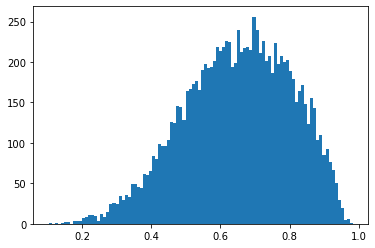

In [22]:
plt.hist(aucs_mtoh, bins=100)

In [23]:
gene_aucs = pd.DataFrame(index=mouse_genes.index, columns=['mouse_auc', 'human_auc'], data=np.array([aucs_mtoh, aucs_htom]).T)

In [24]:
gene_aucs

,mouse_auc,human_auc
HMOX2,0.576908,0.549126
STX2,0.787897,0.798453
RYR2,0.803576,0.760373
DIAPH3,0.448813,0.627500
SLC17A6,0.663413,0.766580
...,...,...
ABCB11,0.490558,0.665805
GLB1L2,0.542298,0.599847
RHBDL2,0.841166,0.672655
TCTN3,0.646876,0.680856


In [25]:
gene_aucs

,mouse_auc,human_auc
HMOX2,0.576908,0.549126
STX2,0.787897,0.798453
RYR2,0.803576,0.760373
DIAPH3,0.448813,0.627500
SLC17A6,0.663413,0.766580
...,...,...
ABCB11,0.490558,0.665805
GLB1L2,0.542298,0.599847
RHBDL2,0.841166,0.672655
TCTN3,0.646876,0.680856


In [26]:
gene_aucs.to_csv("../../data/prepared/aucs.tsv.gz", sep="\t")

In [27]:
spearmanr(gene_aucs.mouse_auc.values, gene_aucs.human_auc.values)

SpearmanrResult(correlation=0.8412367496448544, pvalue=0.0)